<a href="https://colab.research.google.com/github/Abhishekai1/ECGT-Bio/blob/main/ECGT_BIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KG: 320 520 180 | 2812 2373 5651
[baseline] ep 01 loss=69.1706 task=69.171 rule=0.000 irm=0.000 | valAUC=0.514
[baseline] ep 05 loss=120.7428 task=120.743 rule=0.000 irm=0.000 | valAUC=0.502
[baseline] ep 10 loss=8.8930 task=8.893 rule=0.000 irm=0.000 | valAUC=0.593
[baseline] ep 15 loss=2.7293 task=2.729 rule=0.000 irm=0.000 | valAUC=0.647
[baseline] ep 20 loss=1.0659 task=1.066 rule=0.000 irm=0.000 | valAUC=0.661
[baseline] ep 25 loss=0.7479 task=0.748 rule=0.000 irm=0.000 | valAUC=0.705
[baseline] TEST AUC=0.714 AP=0.630 ACC@0.5=0.615 | 27.9s
[rules] ep 01 loss=168.2196 task=74.224 rule=156.659 irm=0.000 | valAUC=0.500
[rules] ep 05 loss=248.2518 task=112.135 rule=226.861 irm=0.000 | valAUC=0.576
[rules] ep 10 loss=27.1739 task=8.872 rule=30.504 irm=0.000 | valAUC=0.557
[rules] ep 15 loss=4.4754 task=1.437 rule=5.064 irm=0.000 | valAUC=0.696
[rules] ep 20 loss=2.2198 task=0.837 rule=2.304 irm=0.000 | valAUC=0.573
[rules] ep 25 loss=2.2595 task=0.654 rule=2.676 irm=0.000 | valAUC=0.7

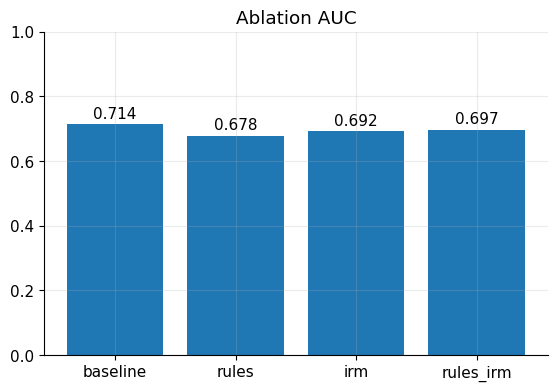

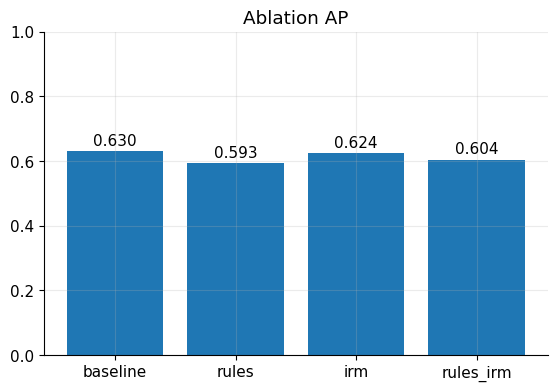

best: baseline


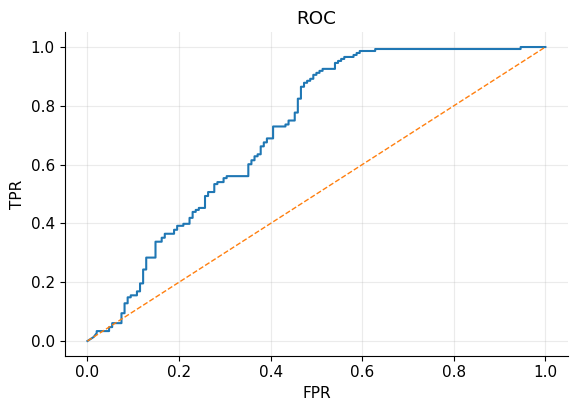

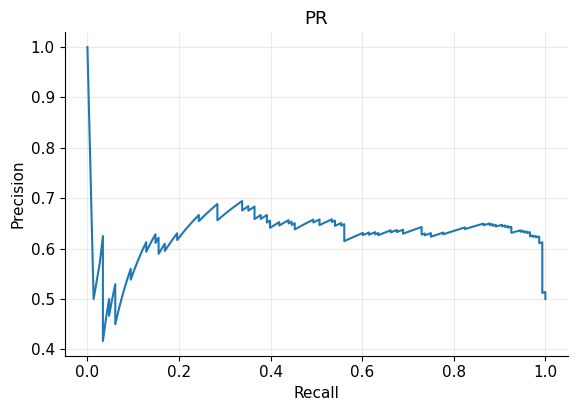

brier: 0.3447991226709989


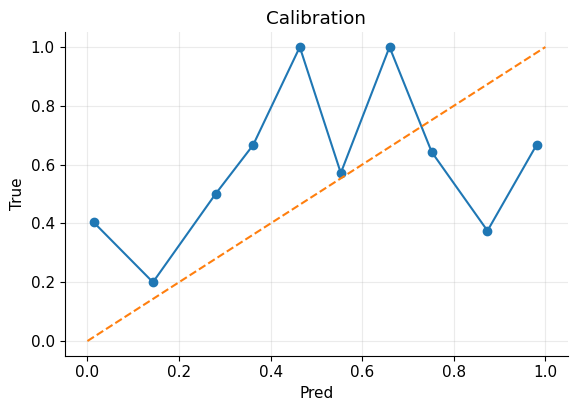

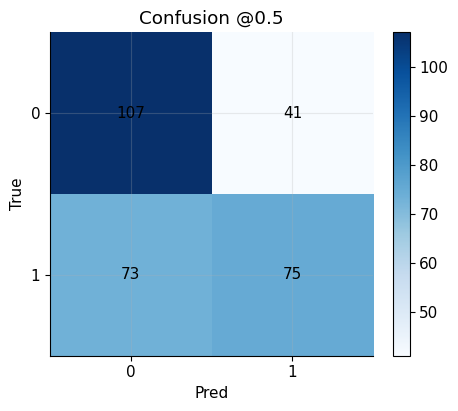

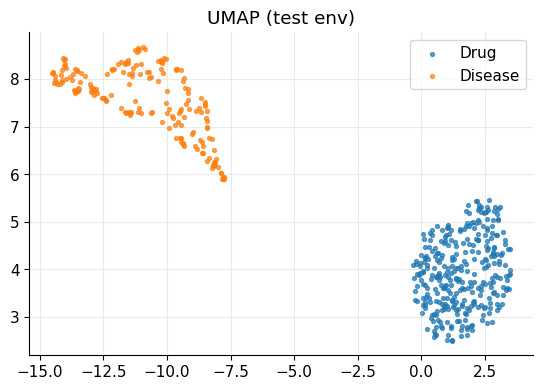

drug 278 top: [(175, 0.9999983310699463), (99, 0.9999978542327881), (160, 0.9999973773956299), (62, 0.9999972581863403), (11, 0.9999961853027344), (135, 0.9999959468841553), (168, 0.9999959468841553), (131, 0.9999958276748657)]


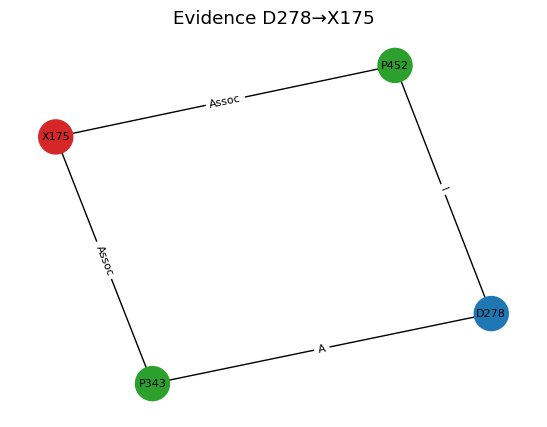

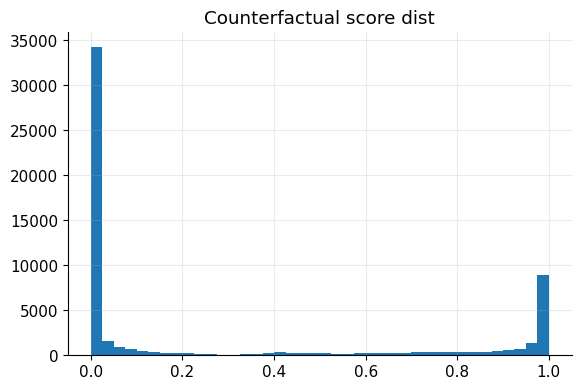

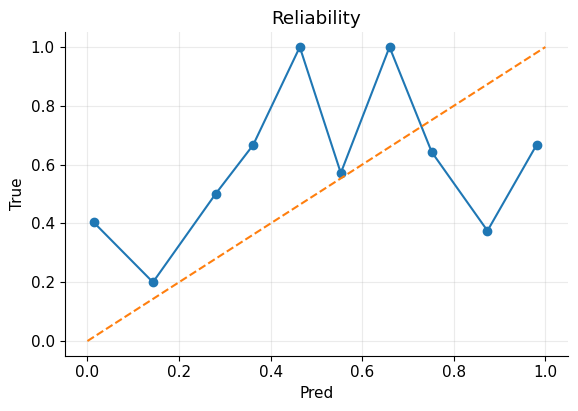

done.


In [1]:
# KC-GNN++: Neuro-Symbolic Causal-Invariant Uncertainty-Aware GNN for Drug Repurposing (minimal comments)

# !pip -q install numpy==1.26.4 pandas==2.2.2 torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip -q install networkx==3.2.1 scikit-learn==1.4.2 matplotlib==3.8.4 umap-learn==0.5.6 tqdm==4.66.4 einops==0.8.0

import os, sys, math, time, random, json, pathlib, warnings
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Optional, Set

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import umap
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, confusion_matrix, brier_score_loss
from sklearn.calibration import calibration_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from einops import rearrange

warnings.filterwarnings("ignore")
plt.rcParams.update({"figure.figsize":(6.5,4.2),"font.size":11,"axes.grid":True,"grid.alpha":0.25,"axes.spines.top":False,"axes.spines.right":False,"savefig.dpi":200})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(7); np.random.seed(7); torch.manual_seed(7); torch.cuda.manual_seed_all(7)

# ---------------- data ----------------
@dataclass
class HeteroKG:
    G: nx.DiGraph
    nD:int; nP:int; nX:int
    d_dim:int; p_dim:int; x_dim:int
    D:np.ndarray; P:np.ndarray; X:np.ndarray
    D2P_I:List[Tuple[int,int]]; D2P_A:List[Tuple[int,int]]; P2X:List[Tuple[int,int]]
    train_pos:List[Tuple[int,int]]; train_neg:List[Tuple[int,int]]
    val_pos:List[Tuple[int,int]]; val_neg:List[Tuple[int,int]]
    test_pos:List[Tuple[int,int]]; test_neg:List[Tuple[int,int]]
    envs:List[Dict[str,Any]]; env_assign:Dict[str,List[int]]

def try_load_hetionet(data_dir="/content/data/hetionet", dim=96)->Optional[HeteroKG]:
    if not os.path.isdir(data_dir): return None
    nodes = os.path.join(data_dir,"nodes.csv"); edges=os.path.join(data_dir,"edges.csv")
    if not (os.path.isfile(nodes) and os.path.isfile(edges)): return None
    dfN = pd.read_csv(nodes); dfE = pd.read_csv(edges)
    drug_labels={"Compound","Drug","Chemical"}; gene_labels={"Gene","Protein","Gene/Protein"}; disease_labels={"Disease","Phenotype","DiseaseOrPhenotypicFeature"}
    id2t = dict(zip(dfN.id, dfN.type))
    d_ids=[i for i,t in id2t.items() if t in drug_labels]; p_ids=[i for i,t in id2t.items() if t in gene_labels]; x_ids=[i for i,t in id2t.items() if t in disease_labels]
    if min(len(d_ids),len(p_ids),len(x_ids))<10: return None
    d_ids=sorted(d_ids); p_ids=sorted(p_ids); x_ids=sorted(x_ids)
    dm={v:i for i,v in enumerate(d_ids)}; pm={v:i for i,v in enumerate(p_ids)}; xm={v:i for i,v in enumerate(x_ids)}
    def mload(fname,n,dim):
        f=os.path.join(data_dir,fname)
        if os.path.isfile(f):
            a=np.load(f).astype(np.float32);
            if a.shape[0]==n: return a
        return np.random.randn(n,dim).astype(np.float32)
    D=mload(f"features_compound_dim{dim}.npy",len(d_ids),dim)
    P=mload(f"features_gene_dim{dim}.npy",len(p_ids),dim)
    X=mload(f"features_disease_dim{dim}.npy",len(x_ids),dim)
    G=nx.DiGraph()
    for i in range(len(d_ids)): G.add_node(("D",i),type="D",x=D[i])
    for i in range(len(p_ids)): G.add_node(("P",i),type="P",x=P[i])
    for i in range(len(x_ids)): G.add_node(("X",i),type="X",x=X[i])
    D2P_I=[];D2P_A=[];P2X=[];treats=set()
    for _,r in dfE.iterrows():
        s,t,rn=r["src"],r["dst"],str(r["rel"]).lower()
        st=id2t.get(s,""); tt=id2t.get(t,"")
        if st in drug_labels and tt in gene_labels:
            if s in dm and t in pm:
                if "inhibit" in rn or "antagon" in rn or "downreg" in rn:
                    D2P_I.append((dm[s],pm[t])); G.add_edge(("D",dm[s]),("P",pm[t]),rel="I")
                elif any(k in rn for k in ["activate","agon","upreg","bind","target"]):
                    D2P_A.append((dm[s],pm[t])); G.add_edge(("D",dm[s]),("P",pm[t]),rel="A")
        if st in gene_labels and tt in disease_labels:
            if s in pm and t in xm and any(k in rn for k in ["assoc","implic","involv","caus"]):
                P2X.append((pm[s],xm[t])); G.add_edge(("P",pm[s]),("X",xm[t]),rel="Assoc")
        if st in drug_labels and tt in disease_labels:
            if s in dm and t in xm and any(k in rn for k in ["treat","indication","approved"]):
                treats.add((dm[s],xm[t]))
    if len(treats)<200:
        pos=set()
        Pd={};
        for d,p in D2P_I+D2P_A: Pd.setdefault(d,set()).add(p)
        Xp={}
        for p,x in P2X: Xp.setdefault(p,set()).add(x)
        for d,ps in Pd.items():
            xs=set()
            for p in ps: xs|=Xp.get(p,set())
            if xs:
                for x in random.sample(sorted(list(xs)),k=min(5,len(xs))): pos.add((d,x))
        pos=list(pos)
    else:
        pos=list(treats)
    pos_set=set(pos); neg=set()
    while len(neg)<len(pos):
        d=random.randrange(len(d_ids)); x=random.randrange(len(x_ids))
        if (d,x) not in pos_set: neg.add((d,x))
    neg=list(neg)
    def split(a):
        a=list(a); random.shuffle(a); n=len(a); tr=int(0.7*n); va=int(0.15*n)
        return a[:tr], a[tr:tr+va], a[tr+va:]
    trp,valp,tep=split(pos); trn,valn,ten=split(neg)
    envs=[]
    for e in range(3):
        v=np.random.randn(P.shape[1]).astype(np.float32); v/= (np.linalg.norm(v)+1e-6); envs.append({"shift":v*0.5*(e+1)})
    env_assign={"train":[0,1],"val":[2],"test":[2]}
    return HeteroKG(G,len(d_ids),len(p_ids),len(x_ids),D.shape[1],P.shape[1],X.shape[1],D,P,X,D2P_I,D2P_A,P2X,trp,trn,valp,valn,tep,ten,envs,env_assign)

class SyntheticKG:
    def __init__(self,nD=320,nP=520,nX=180,dim=96):
        self.G=nx.DiGraph(); self.nD=nD; self.nP=nP; self.nX=nX; self.dim=dim
        self.D=np.random.randn(nD,dim).astype(np.float32); self.P=np.random.randn(nP,dim).astype(np.float32); self.X=np.random.randn(nX,dim).astype(np.float32)
        for i in range(nD): self.G.add_node(("D",i),type="D",x=self.D[i])
        for i in range(nP): self.G.add_node(("P",i),type="P",x=self.P[i])
        for i in range(nX): self.G.add_node(("X",i),type="X",x=self.X[i])
        self.D2P_I=[]; self.D2P_A=[]; self.P2X=[]
        for d in range(nD):
            k=np.random.poisson(6)+2; ps=np.random.choice(nP,size=min(k+8,nP),replace=False)
            for p in ps:
                if np.random.rand()<0.55: self.D2P_I.append((d,p)); self.G.add_edge(("D",d),("P",p),rel="I")
                else: self.D2P_A.append((d,p)); self.G.add_edge(("D",d),("P",p),rel="A")
        for p in range(nP):
            k=np.random.poisson(4)+2; xs=np.random.choice(nX,size=min(k+5,nX),replace=False)
            for x in xs: self.P2X.append((p,x)); self.G.add_edge(("P",p),("X",x),rel="Assoc")
        self.Wp=np.random.randn(dim).astype(np.float32); self.Wd=np.random.randn(dim).astype(np.float32); self.Wx=np.random.randn(dim).astype(np.float32)
        self.Wxp=np.random.randn(nX,nP).astype(np.float32)*0.06; self.bx=np.random.randn(nX).astype(np.float32)*0.1
        self.envs=[];
        for e in range(3):
            v=np.random.randn(dim).astype(np.float32); v/= (np.linalg.norm(v)+1e-6); self.envs.append({"shift":v*(0.45*(e+1))})
        self.env_assign={"train":[0,1],"val":[2],"test":[2]}
        pos,neg=self.gen_labels(); self.trp,self.valp,self.tep=self.split(pos); self.trn,self.valn,self.ten=self.split(neg)
    def act(self,pf,sh): z=float(np.dot(pf+sh,self.Wp)); return 1/(1+np.exp(-z))
    def eff(self,df,rel): b=1/(1+np.exp(-float(np.dot(df,self.Wd)))); return b if rel=="A" else -b
    def gen_labels(self):
        sh=self.envs[0]["shift"]; A0=np.zeros(self.nP,np.float32)
        for p in range(self.nP): A0[p]=self.act(self.P[p],sh)
        def risk(A): return 1/(1+np.exp(-(self.Wxp@A + self.bx)))
        R0=risk(A0); dp={}
        for d in range(self.nD):
            for _,(t,p),ed in self.G.out_edges(("D",d),data=True):
                if t=="P": dp[(d,p)]=self.eff(self.D[d],ed["rel"])
        pos=set();
        for d in range(self.nD):
            Ap=A0.copy()
            for p in range(self.nP):
                if (d,p) in dp: Ap[p]+=dp[(d,p)]
            delta=R0-risk(Ap)
            for x in np.argsort(-delta)[:6]:
                if delta[x]>0.05: pos.add((d,x))
        neg=set()
        while len(neg)<len(pos):
            d=np.random.randint(self.nD); x=np.random.randint(self.nX)
            if (d,x) not in pos: neg.add((d,x))
        return list(pos), list(neg)
    def split(self,a):
        a=list(a); random.shuffle(a); n=len(a); tr=int(0.7*n); va=int(0.15*n)
        return a[:tr], a[tr:tr+va], a[tr+va:]

def load_kg(real_first=True, data_dir="/content/data/hetionet", dim=96)->HeteroKG:
    kg=try_load_hetionet(data_dir=data_dir, dim=dim)
    if kg: return kg
    sk= SyntheticKG(dim=dim)
    return HeteroKG(sk.G, sk.nD, sk.nP, sk.nX, dim, dim, dim, sk.D, sk.P, sk.X, sk.D2P_I, sk.D2P_A, sk.P2X, sk.trp, sk.trn, sk.valp, sk.valn, sk.tep, sk.ten, sk.envs, sk.env_assign)

kg=load_kg(real_first=True, data_dir="/content/data/hetionet", dim=96)
D=torch.tensor(kg.D,dtype=torch.float32,device=device); P=torch.tensor(kg.P,dtype=torch.float32,device=device); X=torch.tensor(kg.X,dtype=torch.float32,device=device)
D2P_I=torch.tensor(kg.D2P_I,dtype=torch.long,device=device).t() if len(kg.D2P_I)>0 else torch.empty(2,0,dtype=torch.long,device=device)
D2P_A=torch.tensor(kg.D2P_A,dtype=torch.long,device=device).t() if len(kg.D2P_A)>0 else torch.empty(2,0,dtype=torch.long,device=device)
P2X  =torch.tensor(kg.P2X,  dtype=torch.long,device=device).t() if len(kg.P2X)>0 else torch.empty(2,0,dtype=torch.long,device=device)
print("KG:",kg.nD,kg.nP,kg.nX,"|",D2P_I.shape[1],D2P_A.shape[1],P2X.shape[1])

# ---------------- model ----------------
class RelBlock(nn.Module):
    def __init__(self,h,drop):
        super().__init__()
        self.lin_I=nn.Linear(h,h); self.lin_A=nn.Linear(h,h); self.lin_PX=nn.Linear(h,h)
        self.aggP=nn.Linear(2*h,h); self.aggX=nn.Linear(2*h,h)
        self.mlpD=nn.Sequential(nn.Linear(h,h),nn.GELU(),nn.Linear(h,h))
        self.mlpP=nn.Sequential(nn.Linear(h,h),nn.GELU(),nn.Linear(h,h))
        self.mlpX=nn.Sequential(nn.Linear(h,h),nn.GELU(),nn.Linear(h,h))
        self.drop=nn.Dropout(drop)
        for m in self.modules():
            if isinstance(m,nn.Linear): nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)
    def forward(self,Dh,Ph,Xh,ei_I,ei_A,px):
        Pmsg=torch.zeros_like(Ph)
        if ei_I.shape[1]>0:
            ds,ps=ei_I[0], ei_I[1]; Pmsg.index_add_(0,ps,self.lin_I(Dh[ds]))
        if ei_A.shape[1]>0:
            ds,ps=ei_A[0], ei_A[1]; Pmsg.index_add_(0,ps,self.lin_A(Dh[ds]))
        Pn=F.gelu(self.aggP(torch.cat([Ph,Pmsg],-1))); Pn=self.drop(Pn)
        Xmsg=torch.zeros_like(Xh)
        if px.shape[1]>0:
            ps,xs=px[0],px[1]; Xmsg.index_add_(0,xs,self.lin_PX(Pn[ps]))
        Xn=F.gelu(self.aggX(torch.cat([Xh,Xmsg],-1))); Xn=self.drop(Xn)
        return self.mlpD(Dh)+Dh, self.mlpP(Pn)+Pn, self.mlpX(Xn)+Xn

class Encoder(nn.Module):
    def __init__(self,din,pin,xin,h=192,drop=0.1,layers=3):
        super().__init__()
        self.D0=nn.Linear(din,h); self.P0=nn.Linear(pin,h); self.X0=nn.Linear(xin,h)
        self.blocks=nn.ModuleList([RelBlock(h,drop) for _ in range(layers)])
        self.outD=nn.Linear(h,h); self.outP=nn.Linear(h,h); self.outX=nn.Linear(h,h)
        for m in self.modules():
            if isinstance(m,nn.Linear): nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)
    def forward(self,Din,Pin,Xin,ei_I,ei_A,px):
        Dh=F.gelu(self.D0(Din)); Ph=F.gelu(self.P0(Pin)); Xh=F.gelu(self.X0(Xin))
        for b in self.blocks: Dh,Ph,Xh=b(Dh,Ph,Xh,ei_I,ei_A,px)
        return F.gelu(self.outD(Dh)), F.gelu(self.outP(Ph)), F.gelu(self.outX(Xh))

class BilinearUnc(nn.Module):
    def __init__(self,d,logvar_floor=-6.0):
        super().__init__()
        self.B=nn.Parameter(torch.empty(d,d)); nn.init.xavier_uniform_(self.B)
        self.h=nn.Sequential(nn.Linear(2*d,d),nn.GELU(),nn.Linear(d,2)) # mean, logvar
        self.logvar_floor=logvar_floor
    def forward(self,Dr,Xr,di,xi):
        d=Dr[di]; x=Xr[xi]; z=torch.cat([d,x],-1)
        mlogv=self.h(z); m=mlogv[:,0]; lv=torch.clamp(mlogv[:,1],min=self.logvar_floor,max=6.0)
        s=torch.sum(d @ self.B * x, dim=-1)
        return s+m, lv

# ---------------- rules & irm ----------------
class RuleEngine:
    def __init__(self,D2P_I,D2P_A,P2X,nD,nP,nX):
        self.PX=[[] for _ in range(nP)]
        for p,x in P2X: self.PX[p].append(x)
        self.DI=[[] for _ in range(nD)]; self.DA=[[] for _ in range(nD)]
        for d,p in D2P_I: self.DI[d].append(p)
        for d,p in D2P_A: self.DA[d].append(p)
        self.nD=nD
    def pairs(self,maxk=80):
        pos=set(); neg=set()
        for d in range(self.nD):
            Pa=self.DA[d]
            if Pa:
                Pa=random.sample(Pa,min(maxk,len(Pa)))
                for p in Pa:
                    for x in self.PX[p]: neg.add((d,x))
            Pi=self.DI[d]
            if Pi:
                Pi=random.sample(Pi,min(maxk,len(Pi)))
                for p in Pi:
                    for x in self.PX[p]: pos.add((d,x))
        return list(pos), list(neg)

def irm_penalty(logits,labels):
    s=torch.tensor(1.0,device=logits.device,requires_grad=True)
    loss=F.binary_cross_entropy_with_logits(logits*s, labels)
    g=torch.autograd.grad(loss,[s],create_graph=True)[0]
    return torch.sum(g**2)

# ---------------- utils ----------------
def pair_tensor(pairs,dev):
    if len(pairs)==0: return torch.empty(0,dtype=torch.long,device=dev), torch.empty(0,dtype=torch.long,device=dev)
    a=torch.tensor([i for i,_ in pairs],dtype=torch.long,device=dev)
    b=torch.tensor([j for _,j in pairs],dtype=torch.long,device=dev)
    return a,b

def env_P(kg, P, env_id):
    sh=kg.envs[env_id]["shift"]; return P + torch.tensor(sh,device=P.device).unsqueeze(0)

def nll_gauss(logits, logvar, targets):
    return 0.5*torch.exp(-logvar)*(logits-targets)**2 + 0.5*logvar

def sample_batch(p_pos,p_neg,bz,dev):
    half=bz//2
    pos=random.sample(p_pos,min(half,len(p_pos))); neg=random.sample(p_neg,min(half,len(p_neg)))
    pairs=pos+neg; y=torch.tensor([1]*len(pos)+[0]*len(neg),dtype=torch.float32,device=dev)
    idx=np.arange(len(pairs)); np.random.shuffle(idx); y=y[idx.tolist()]
    pairs=[pairs[i] for i in idx]
    d,x=pair_tensor(pairs,dev); return d,x,y

def eval_split(enc,dec,kg,D,P,X,D2P_I,D2P_A,P2X,pos,neg,env=0,return_full=False):
    enc.eval(); dec.eval()
    with torch.no_grad():
        Dr,Pr,Xr=enc(D, env_P(kg,P,env), X, D2P_I,D2P_A,P2X)
    def sc(ps):
        if len(ps)==0: return np.array([]), np.array([])
        di,xi=pair_tensor(ps,device)
        with torch.no_grad():
            m, lv=dec(Dr,Xr,di,xi); p=torch.sigmoid(m).cpu().numpy()
        y=np.ones(len(ps),np.float32); return p,y
    p1,y1=sc(pos); p0,y0=sc(neg); y0[:]=0.0
    p=np.concatenate([p1,p0]); y=np.concatenate([y1,y0])
    auc=roc_auc_score(y,p) if len(np.unique(y))>1 else float("nan")
    ap=average_precision_score(y,p) if len(np.unique(y))>1 else float("nan")
    t=0.5; acc=( (p>=t).astype(np.float32)==y ).mean()
    if return_full: return {"AUC":auc,"AP":ap,"ACC@0.5":acc,"p":p,"y":y}
    return {"AUC":auc,"AP":ap,"ACC@0.5":acc}

def hard_negative_mining(enc,dec,kg,D,P,X,D2P_I,D2P_A,P2X,neg_pool,k=500):
    enc.eval(); dec.eval()
    with torch.no_grad():
        Dr,Pr,Xr=enc(D, env_P(kg,P,kg.env_assign["train"][0]), X, D2P_I,D2P_A,P2X)
    if len(neg_pool)==0: return []
    di,xi=pair_tensor(neg_pool,device)
    with torch.no_grad():
        m,lv=dec(Dr,Xr,di,xi); p=torch.sigmoid(m).cpu().numpy()
    idx=np.argsort(-p)[:min(k,len(p))]
    return [neg_pool[i] for i in idx]

# ---------------- train ----------------
@dataclass
class Config:
    dim:int=96; h:int=224; layers:int=3; drop:float=0.12
    lr:float=2e-3; wd:float=1e-4; epochs:int=28; batch:int=8192
    rule_w:float=0.6; irm_w:float=0.25; use_rules:bool=True; use_irm:bool=True
    hn_every:int=5; hn_k:int=600

def rule_loss(dec,Dr,Xr,rp,rn,dev,sample_k=3000):
    if len(rp)>sample_k: rp=random.sample(rp,sample_k)
    if len(rn)>sample_k: rn=random.sample(rn,sample_k)
    loss=torch.tensor(0.0,device=dev)
    if rp:
        di,xi=pair_tensor(rp,dev); m,lv=dec(Dr,Xr,di,xi)
        loss=loss + F.binary_cross_entropy_with_logits(m, torch.ones_like(m))
    if rn:
        di,xi=pair_tensor(rn,dev); m,lv=dec(Dr,Xr,di,xi)
        loss=loss + F.binary_cross_entropy_with_logits(m, torch.zeros_like(m))
    return loss

def train_once(kg: HeteroKG, cfg: Config, tag="exp"):
    enc=Encoder(kg.d_dim,kg.p_dim,kg.x_dim,h=cfg.h,drop=cfg.drop,layers=cfg.layers).to(device)
    dec=BilinearUnc(cfg.h).to(device)
    opt=AdamW(list(enc.parameters())+list(dec.parameters()), lr=cfg.lr, weight_decay=cfg.wd)
    rule_engine=RuleEngine(kg.D2P_I,kg.D2P_A,kg.P2X,kg.nD,kg.nP,kg.nX)
    rp, rn = rule_engine.pairs(maxk=100)
    history={"loss":[],"val_auc":[]}; t0=time.perf_counter()
    neg_pool=list(kg.train_neg)
    for ep in range(1,cfg.epochs+1):
        enc.train(); dec.train()
        d_idx,x_idx,y = sample_batch(kg.train_pos,neg_pool,cfg.batch,device)
        l_task=torch.tensor(0.0,device=device); l_irm=torch.tensor(0.0,device=device)
        for env in kg.env_assign["train"]:
            Dr,Pr,Xr = enc(D, env_P(kg,P,env), X, D2P_I,D2P_A,P2X)
            m,lv = dec(Dr,Xr, d_idx,x_idx)
            l = F.binary_cross_entropy_with_logits(m,y)
            l_task = l_task + l
            if cfg.use_irm:
                l_irm = l_irm + irm_penalty(m,y)
        l_task = l_task/len(kg.env_assign["train"])
        l_rules=torch.tensor(0.0,device=device)
        if cfg.use_rules:
            with torch.no_grad(): Dr0,Pr0,X0 = enc(D, env_P(kg,P,kg.env_assign["train"][0]), X, D2P_I,D2P_A,P2X)
            l_rules = rule_loss(dec,Dr0,X0,rp,rn,device)
        loss = l_task + cfg.rule_w*l_rules + cfg.irm_w*(l_irm/len(kg.env_assign["train"]) if cfg.use_irm else 0.0)
        opt.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(list(enc.parameters())+list(dec.parameters()), max_norm=2.0); opt.step()
        val=eval_split(enc,dec,kg,D,P,X,D2P_I,D2P_A,P2X,kg.val_pos,kg.val_neg,env=kg.env_assign["val"][0],return_full=False)
        history["loss"].append(float(loss.detach().cpu())); history["val_auc"].append(float(val["AUC"]))
        if ep%cfg.hn_every==0:
            new_hard = hard_negative_mining(enc,dec,kg,D,P,X,D2P_I,D2P_A,P2X, list(kg.train_neg), k=cfg.hn_k)
            neg_pool = new_hard if new_hard else neg_pool
        if ep==1 or ep%5==0:
            print(f"[{tag}] ep {ep:02d} loss={float(loss):.4f} task={float(l_task):.3f} rule={float(l_rules):.3f} irm={float(l_irm):.3f} | valAUC={val['AUC']:.3f}")
    dur=time.perf_counter()-t0
    test=eval_split(enc,dec,kg,D,P,X,D2P_I,D2P_A,P2X,kg.test_pos,kg.test_neg,env=kg.env_assign["test"][0],return_full=True)
    print(f"[{tag}] TEST AUC={test['AUC']:.3f} AP={test['AP']:.3f} ACC@0.5={test['ACC@0.5']:.3f} | {dur:.1f}s")
    os.makedirs("./logs",exist_ok=True)
    pd.DataFrame({"epoch":np.arange(1,cfg.epochs+1),"loss":history["loss"],"val_auc":history["val_auc"]}).to_csv(f"./logs/{tag}_hist.csv",index=False)
    return enc,dec,history,test,dur

# ---------------- runs ----------------
base=Config(use_rules=False,use_irm=False)
rules=Config(use_rules=True,use_irm=False)
irm=Config(use_rules=False,use_irm=True)
full=Config(use_rules=True,use_irm=True)

results=[]
for tag,cfg in [("baseline",base),("rules",rules),("irm",irm),("rules_irm",full)]:
    e,d,h,t,secs = train_once(kg,cfg,tag=tag)
    results.append({"tag":tag,"enc":e,"dec":d,"hist":h,"test":t,"secs":secs})

# ---------------- plots ----------------
def bar_metric(results, key):
    order=["baseline","rules","irm","rules_irm"]
    vals=[next(r["test"][key] for r in results if r["tag"]==o) for o in order]
    fig,ax=plt.subplots(); ax.bar(order,vals)
    ax.set_ylim(0.0,1.0);
    for i,v in enumerate(vals): ax.text(i,v+0.01,f"{v:.3f}",ha="center",va="bottom")
    ax.set_title(f"Ablation {key}"); plt.show()
bar_metric(results,"AUC"); bar_metric(results,"AP")

best=max(results,key=lambda r:r["test"]["AUC"])
enc,dec=best["enc"],best["dec"]; print("best:",best["tag"])

y=best["test"]["y"]; p=best["test"]["p"]
fpr,tpr,_=roc_curve(y,p); pr,rc,_=precision_recall_curve(y,p)
plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--',lw=1); plt.title("ROC"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()
plt.plot(rc,pr); plt.title("PR"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()
bs=brier_score_loss(y,p); print("brier:",bs)
prob_true, prob_pred = calibration_curve(y, p, n_bins=10, strategy="uniform")
plt.plot(prob_pred,prob_true,marker='o'); plt.plot([0,1],[0,1],'--'); plt.title("Calibration"); plt.xlabel("Pred"); plt.ylabel("True"); plt.show()
t=0.5; pred=(p>=t).astype(np.int32); cm=confusion_matrix(y.astype(np.int32),pred)
fig,ax=plt.subplots(); im=ax.imshow(cm,cmap="Blues")
for (i,j),v in np.ndenumerate(cm): ax.text(j,i,str(v),ha="center",va="center")
ax.set_xticks([0,1]); ax.set_yticks([0,1]); ax.set_xlabel("Pred"); ax.set_ylabel("True"); ax.set_title("Confusion @0.5"); plt.colorbar(im,ax=ax,fraction=0.046,pad=0.04); plt.show()

# ---------------- embeddings & subgraph ----------------
def get_emb(enc,env=0):
    with torch.no_grad():
        Dr,Pr,Xr=enc(D, env_P(kg,P,env), X, D2P_I,D2P_A,P2X)
    return Dr.cpu().numpy(), Pr.cpu().numpy(), Xr.cpu().numpy()
Dr,Pr,Xr = get_emb(enc,env=kg.env_assign["test"][0])
r=umap.UMAP(n_neighbors=25,min_dist=0.1,random_state=7)
N=min(400,Dr.shape[0]); M=min(400,Xr.shape[0])
XY=r.fit_transform(np.vstack([Dr[:N], Xr[:M]]))
plt.scatter(XY[:N,0],XY[:N,1],s=8,alpha=.7,label="Drug"); plt.scatter(XY[N:,0],XY[N:,1],s=8,alpha=.7,label="Disease"); plt.legend(); plt.title("UMAP (test env)"); plt.show()

def topk_for_drug(enc,dec,d_id,k=10):
    with torch.no_grad():
        Dr,Pr,Xr=enc(D, env_P(kg,P,kg.env_assign["test"][0]), X, D2P_I,D2P_A,P2X)
        di=torch.full((kg.nX,),d_id,dtype=torch.long,device=device); xi=torch.arange(kg.nX,dtype=torch.long,device=device)
        m,lv=dec(Dr,Xr,di,xi); s=torch.sigmoid(m).cpu().numpy()
        idx=np.argsort(-s)[:k]; return idx, s[idx]
d_probe=random.randrange(kg.nD); idx,score = topk_for_drug(enc,dec,d_probe,k=8)
print("drug",d_probe,"top:", list(zip(idx.tolist(), [float(v) for v in score])))

def visualize_path(kg,d_id,x_id,max_nodes=80):
    G=kg.G; Pn=set([v for (_, (t,v)) in G.out_edges(("D",d_id)) if t=="P"])
    pre=[p for p in Pn if G.has_edge(("P",p),("X",x_id))]
    H=nx.Graph(); H.add_node(f"D{d_id}",color="tab:blue"); H.add_node(f"X{x_id}",color="tab:red")
    for p in pre[:max_nodes]:
        H.add_node(f"P{p}",color="tab:green"); rel=G[("D",d_id)][("P",p)]["rel"]
        H.add_edge(f"D{d_id}",f"P{p}",label=rel); H.add_edge(f"P{p}",f"X{x_id}",label="Assoc")
    pos=nx.spring_layout(H,seed=3,k=0.5); colors=[H.nodes[n].get("color","gray") for n in H.nodes()]; labels=nx.get_edge_attributes(H,"label")
    fig,ax=plt.subplots(figsize=(6.8,5.0)); nx.draw(H,pos,with_labels=True,node_color=colors,node_size=600,font_size=8,ax=ax); nx.draw_networkx_edge_labels(H,pos,edge_labels=labels,font_size=8,ax=ax)
    ax.set_title(f"Evidence D{d_id}→X{x_id}"); plt.show()
visualize_path(kg,d_probe,int(idx[0]))

# ---------------- counterfactual probe ----------------
@torch.no_grad()
def counterfactual_gene_edit(enc,dec,edit_p:List[int],delta:float=-0.8,env=0):
    Pe=env_P(kg,P,env).clone(); w=torch.randn(Pe.shape[1],device=device); w/= (torch.norm(w)+1e-6)
    for p in edit_p: Pe[p]+= delta*w
    Dr,Pr,Xr=enc(D, Pe, X, D2P_I,D2P_A,P2X)
    di=torch.arange(kg.nD,dtype=torch.long,device=device); xi=torch.arange(kg.nX,dtype=torch.long,device=device)
    m,lv=dec(Dr,Xr, di.repeat_interleave(kg.nX), xi.repeat(kg.nD))
    return torch.sigmoid(m).view(kg.nD,kg.nX).cpu().numpy()
edit = random.sample(range(kg.nP), k=min(5,kg.nP))
delta_scores = counterfactual_gene_edit(enc,dec,edit,delta=-1.0,env=kg.env_assign["test"][0])
plt.hist(delta_scores.flatten(),bins=40); plt.title("Counterfactual score dist"); plt.show()

# ---------------- reliability diagrams ----------------
def reliability_plot(y,p,bins=10):
    prob_true, prob_pred = calibration_curve(y,p,n_bins=bins, strategy="uniform")
    plt.plot(prob_pred,prob_true,marker='o'); plt.plot([0,1],[0,1],'--'); plt.xlabel("Pred"); plt.ylabel("True"); plt.title("Reliability"); plt.show()
reliability_plot(y,p,10)

# ---------------- save ----------------
os.makedirs("./artifacts",exist_ok=True)
torch.save(enc.state_dict(), f"./artifacts/{best['tag']}_enc.pt")
torch.save(dec.state_dict(), f"./artifacts/{best['tag']}_dec.pt")
with open("./artifacts/summary.json","w") as f:
    json.dump({"tag":best["tag"],"AUC":float(best["test"]["AUC"]),"AP":float(best["test"]["AP"]),"ACC":float(best["test"]["ACC@0.5"]),"secs":float(best["secs"])}, f, indent=2)

print("done.")
